In [189]:
import os
import gdal
import rasterio as rio
from env_vars import host,username,PGPASSWORD,port
from glob import glob
import psycopg2 as ps
import numpy as np
import earthpy.plot as ep

In [139]:
small_raster_directory = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2/Polygon_Crops/MSK/Chips/yes/"
large_raster_directory = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2/Polygon_Crops/MSK/Individual_Polygons/TIF"

small_raster_file_list = glob(f'{small_raster_directory}/*/*')
large_raster_file_list = glob(f'{large_raster_directory}/*')


In [119]:
src_raster_file = rio.open(raster_file_list[0])

In [120]:
crs = str(src_raster_file.meta["crs"]).split(":")[-1]

In [121]:
crs

'4326'

In [122]:
dims = str(src_raster_file.meta["width"]) + "x" + str(src_raster_file.meta["height"])

In [123]:
dims

'100x100'

In [124]:
# data_import = "data_import." + "_".join(sample_filepath.split("/")[-1].split(".")[0].split("_")[1:])

In [125]:
!ulimit -s 65532

In [126]:
# # single image upload

# command = f"raster2pgsql -s {crs} -C -l 2,4 -I -F -t {dims} {chip_list[0]} public.gistest1 -d | PGPASSWORD={PGPASSWORD} psql -h {host} -p {port} -U {username} -d postgres"

In [127]:
# os.system(command)

# Working First Chip

In [140]:
# # Working first chip upload

command = f"raster2pgsql -s {crs} -l 2,4 -F -t 200x200 {large_raster_file_list[0]} public.gistest1 -d | PGPASSWORD={PGPASSWORD} psql -h {host} -p {port} -U {username} -d postgres"

In [141]:
os.system(command)

0

In [142]:
# last_file = "3_2600_1800.tif"

# chip_list[1739:1750]


# Working Subsequent Raster Upload Code

In [143]:
for chip in large_raster_file_list[1:]:
    command = f"raster2pgsql -s {crs} -F -t 200x200 {chip} public.gistest1 -a | PGPASSWORD={PGPASSWORD} psql -h {host} -p {port} -U {username} -d postgres"
    os.system(command)
    

In [ ]:
# raster2pgsql -s 4326 -C -l 2,4 -I -F -t 2700x2700 gray_50m_sr_ob.tif data_import.gray_50m_sr_ob | psql -h localhost -p 5434 -U postgres -d mastering_postgis

# Sandbox / Queries

In [144]:
conn = ps.connect(host=host,
                          database="postgres",
                          user=username,
                          password=PGPASSWORD,
                          port=port)
cur = conn.cursor()

In [145]:
cur.execute("SELECT * from gistest1")
file_list = cur.fetchall()

In [154]:
help(gdal.InfoOptions)

Help on function InfoOptions in module osgeo.gdal:

InfoOptions(options=None, format='text', deserialize=True, computeMinMax=False, reportHistograms=False, reportProj4=False, stats=False, approxStats=False, computeChecksum=False, showGCPs=True, showMetadata=True, showRAT=True, showColorTable=True, listMDD=False, showFileList=True, allMetadata=False, extraMDDomains=None, wktFormat=None)
    Create a InfoOptions() object that can be passed to gdal.Info()
    options can be be an array of strings, a string or let empty and filled from other keywords.



In [162]:
rast_one = file_list[0][1]

In [166]:
bytes(rast_one)

TypeError: string argument without an encoding

In [184]:
# Use a virtual memory file, which is named like this
vsipath = '/vsimem/from_postgis'

# Download raster data into Python as GeoTIFF, and make a virtual file for GDAL
cur.execute("SELECT ST_AsGDALRaster(rast, 'GTiff') FROM gistest1;")
gdal.FileFromMemBuffer(vsipath, bytes(cur.fetchone()[0]))

# Read first band of raster with GDAL
ds = gdal.Open(vsipath)
# band = ds.GetRasterBand(1)
arr = ds.ReadAsArray()

# Close and clean up virtual memory file
# ds = band = None
gdal.Unlink(vsipath)

print(ds)  # this is a 2D numpy array



<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x113ac1630> >


In [187]:
arr.shape

(3, 200, 200)

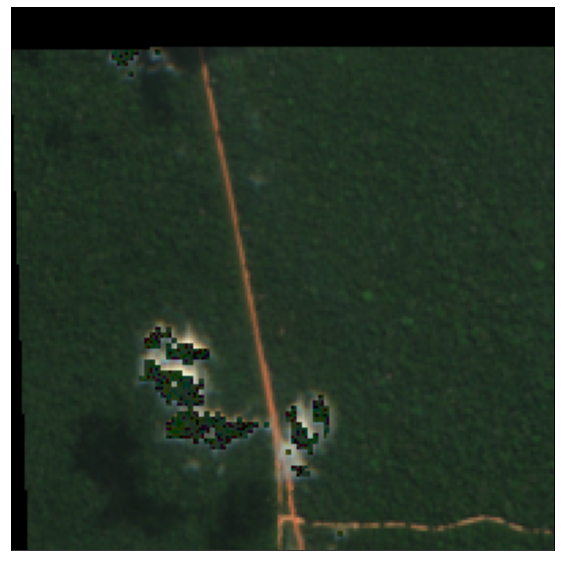

In [193]:
ep.plot_rgb(arr);

In [182]:
print(ds)

None


In [170]:
arr.shape

(200, 200)

In [116]:
len(file_list)

19121

In [21]:
file_list[0]

('1_0_0.tif',)

In [22]:
chip_list[0]

'/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2/Polygon_Crops/MSK/Chips/full/1/1_0_0.tif'

In [23]:
chip_files = {}
for chip_file in chip_list:
    chip_files[chip_file.split("/")[-1]] = chip_file

len(chip_files)

21124

In [24]:
inserted_files = []
for inserted_file in file_list:
    inserted_files.append(inserted_file[0])
    
len(inserted_files)

19121

In [25]:
not_inserted = list(set(chip_files) ^ set(inserted_files))

In [26]:
for_insertion = []
for file in not_inserted:
    for_insertion.append(chip_files[file])

len(for_insertion)

2006

In [27]:
for_insertion[0:2]

['/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2/Polygon_Crops/MSK/Chips/full/18/18_4800_4000.tif',
 '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2/Polygon_Crops/MSK/Chips/full/18/18_4800_3000.tif']

In [61]:
for rast_bad in for_insertion:
    src_raster_file_bad = rio.open(rast_bad)
    np_bad = src_raster_file_bad.read()
    print(np.count_nonzero(np_bad))
    
    

# src_raster_file_bad = rio.open(for_insertion[2000])
# src_raster_file_bad.meta

# gdal.Info(for_insertion[0])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [57]:
np_bad = src_raster_file_bad.read()
np.count_nonzero(np_bad)

0

In [64]:
rast_bad_list = []
for rast_good in chip_list:
    src_raster_file_good = rio.open(rast_good)
    np_good = src_raster_file_good.read()
    if np.count_nonzero(np_good) == 0:
        rast_bad_list.append(rast_good)

len(rast_bad_list)

2006

In [48]:
src_raster_file_good = rio.open(chip_list[0])
src_raster_file_good.meta

# gdal.Info(chip_list[0])

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 100,
 'height': 100,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(9.017313858931765e-05, 0.0, 17.173849715980833,
        0.0, -9.017313858912979e-05, 2.6760005155859083)}

In [58]:
np_good = src_raster_file_good.read()

In [59]:
np.count_nonzero(np_good)

25056